In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/ccnlab/Development/dl4rl/')

import numpy as np
import pandas as pd
import tqdm

from sequence_generator import create_stim_sequence
from rl_models import PRL
from utils.simulate_utils import generate_valid_mappings
from concurrent.futures import ProcessPoolExecutor
from sim_agent import simulate_agent
import random
from utils.simulate_utils import generate_beta_with_diff_means_sim_vars


In [3]:
pval=1
num_blocks = 12

num_stimuli_list = [6, 6]
min_switches = [1200, 1200]
iter_per_stimuli = 13
num_actions = 3

all_seq = []
for i in range(num_blocks):
  all_seq.append(create_stim_sequence(iter_per_stimuli, num_stimuli_list[0]))


In [36]:
# Prepare the sequences

N_AGENTS = 3000
mean1 = 0.1
var = 0.01  # Variance of both distributions
phi_dist, _, _, _, _, _ = generate_beta_with_diff_means_sim_vars(mean1, 0.1, var, N_AGENTS, 0, 0.4)
# simulate N_AGENTS agents with randomly sampled alphas and betas

sticky_dist = np.random.uniform(-0.2, 0.2, N_AGENTS)
with ProcessPoolExecutor() as executor:
    futures = [executor.submit(simulate_agent, a, pval, num_blocks, num_stimuli_list, min_switches, iter_per_stimuli, num_actions, all_seq, sticky_dist, phi_dist) for a in range(N_AGENTS)]
    train_data_list = [future.result() for future in tqdm.tqdm(futures)]

train_df = pd.concat(train_data_list)
train_df.head(3)

100%|██████████| 3000/3000 [00:24<00:00, 122.74it/s]


,agentid,actions,stimuli,correct_actions,rewards,trials,isswitch,iscorrectaction,alpha,beta,phi,stickiness,rpe_history,unchosen_rpe_history,last_correct_trial,delay_since_last_correct,block_no,condition,set_size
0,0,1,0,2,0,0,0,0,0.479433,13.100751,0.216639,0.092644,-0.333333,0.666667,NaN,0,0,1,6
1,0,2,1,1,0,1,0,0,0.479433,13.100751,0.216639,0.092644,-0.333333,0.666667,NaN,0,0,1,6
2,0,0,2,1,0,2,0,0,0.479433,13.100751,0.216639,0.092644,-0.333333,0.666667,NaN,0,0,1,6


In [37]:
max_num_trials = train_df.trials.max()+1
filename = f"../data/rlf_6s3a/{N_AGENTS}a_{num_blocks}b_{max_num_trials}t_3ParamRL_no_switch_st22.csv"
print(filename)
train_df.to_csv(filename)

../data/rlf_6s3a/3000a_12b_78t_3ParamRL_no_switch_st22.csv


/var/folders/6y/khb9drcn0p373bwf72szrzvm0000gn/T/ipykernel_64784/1118997354.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  ax = sns.pointplot(


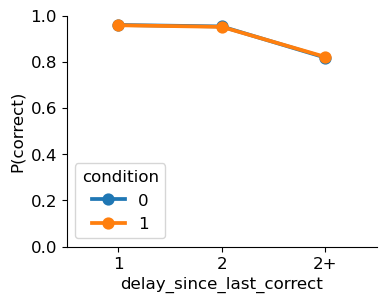

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

train_df['delay_since_last_correct_cat'] = train_df['delay_since_last_correct'].apply(lambda x: '2+' if x > 2 else str(x))
#train_df[['stimuli', 'trials', 'rewards', 'delay_since_last_correct']].tail(10)
res = train_df[train_df.delay_since_last_correct > 0]
res = (
    res.groupby(["agentid", "delay_since_last_correct_cat", "condition"])[["rewards"]]
    .mean()
    .reset_index()
)

plt.rcParams.update({"font.size": 12})
fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharey=True)
ax = sns.pointplot(
    data=res,
    x="delay_since_last_correct_cat",
    y="rewards",
    order=['1', '2', '2+'],
    hue="condition",
    ax=ax,
    ci=95,
)
ax.set_xlabel("delay_since_last_correct")
ax.set_ylabel("P(correct)")
ax.set_yticks(np.round(np.arange(0, 1.2, 0.2), 2))

sns.despine()

In [33]:
from utils.feature_utils import get_iter_acc_without_switches
iter_acc = get_iter_acc_without_switches(train_df)
iter_acc.head(2)

,stim_iter,stimuli,rewards,condition,actions,trials,agentid,block_no
0,1,0,1,1,2,0,0,0
1,1,1,1,1,0,1,0,0


/var/folders/6y/khb9drcn0p373bwf72szrzvm0000gn/T/ipykernel_64784/3968031415.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  ax = sns.pointplot(


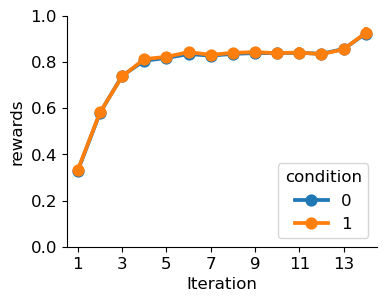

In [34]:
res = (
    iter_acc.groupby(["agentid", "stim_iter", "condition"])[["rewards"]]
    .mean()
    .reset_index()
)

plt.rcParams.update({"font.size": 12})
fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharey=True)
ax = sns.pointplot(
    data=res,
    x="stim_iter",
    y="rewards",
    hue="condition",
    ax=ax,
    ci=95,
)
ax.set_xlabel("Iteration")
#ax.hlines(0.33, xmin=0, xmax=18, color='red')
max_num_iter = res.stim_iter.max()
ax.set_xticks(np.round(np.arange(0, max_num_iter, 2), 2))
ax.set_yticks(np.round(np.arange(0, 1.2, 0.2), 2))

#fig.tight_layout(rect=[0, 0, 1, 0.95])

sns.despine()